#### no aging

#### Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def initialize_grid(Nb, Nr):
    grid = np.zeros((200, 200))
    blue_agents = np.random.choice(40000, Nb, replace=False)
    red_agents = np.random.choice([x for x in range(40000) if x not in blue_agents], Nr, replace=False)
    grid.flat[blue_agents] = 1
    grid.flat[red_agents] = -1
    return grid

def compute_fraction(grid, kernel):
    sum_neighbors_blue = convolve2d(grid == 1, kernel, mode='same', boundary='fill', fillvalue=0)
    sum_neighbors_red = convolve2d(grid == -1, kernel, mode='same', boundary='fill', fillvalue=0)
    total_neighbors = sum_neighbors_blue + sum_neighbors_red + 1e-6
    fraction_blue = sum_neighbors_blue / total_neighbors
    fraction_red = sum_neighbors_red / total_neighbors
    return fraction_blue, fraction_red

def find_unhappy_cells(grid, fraction_blue, fraction_red, jt):
    unhappy_blue = (grid == 1) & (fraction_blue < jt) 
    unhappy_red = (grid == -1) & (fraction_red < jt)
    return unhappy_blue | unhappy_red

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def initialize_grid(Nb, Nr):
    grid = np.zeros((200, 200))
    blue_agents = np.random.choice(40000, Nb, replace=False)
    red_agents = np.random.choice([x for x in range(40000) if x not in blue_agents], Nr, replace=False)
    grid.flat[blue_agents] = 1
    grid.flat[red_agents] = -1
    return grid

def compute_fraction(grid, kernel):
    sum_neighbors_blue = convolve2d(grid == 1, kernel, mode='same', boundary='wrap', fillvalue=0)
    sum_neighbors_red = convolve2d(grid == -1, kernel, mode='same', boundary='wrap', fillvalue=0)
    total_neighbors = sum_neighbors_blue + sum_neighbors_red + 1e-6
    fraction_blue = sum_neighbors_blue / total_neighbors
    fraction_red = sum_neighbors_red / total_neighbors
    return fraction_blue, fraction_red

def find_unhappy_cells(grid, fraction_blue, fraction_red, jt):
    unhappy_blue = (grid == 1) & (fraction_blue < jt) 
    unhappy_red = (grid == -1) & (fraction_red < jt)
    return unhappy_blue | unhappy_red


def main_loop(grid, jt, max_iter):
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    age_grid = np.zeros_like(grid)  # Initialize age grid
    iterations = 0

    while iterations < max_iter:
        fraction_blue, fraction_red = compute_fraction(grid, kernel)
        unhappy_cells = find_unhappy_cells(grid, fraction_blue, fraction_red, jt)

        for pos in zip(*np.where(unhappy_cells)):
            x, y = pos

            # Determine if the agent will move based on its age
            if np.random.rand() < 1 / (2 + age_grid[x, y]):
                # Get the current list of empty cells
                empty_cells = np.where(grid == 0)

                # If there are no satisfying positions, move to a random empty position
                if len(empty_cells[0]) == 0:
                    random_empty_index = np.random.choice(len(empty_cells[0]), 1)[0]
                    new_x, new_y = empty_cells[0][random_empty_index], empty_cells[1][random_empty_index]
                else:
                    # Filter satisfying positions based on agent type
                    if grid[x, y] == 1:  # Blue agent
                        satisfying_positions = [(i, j) for i, j in zip(*empty_cells) if fraction_blue[i, j] >= jt]
                    else:  # Red agent
                        satisfying_positions = [(i, j) for i, j in zip(*empty_cells) if fraction_red[i, j] >= jt]

                    # If satisfying positions are available, move to one of them
                    if satisfying_positions:
                        new_x, new_y = satisfying_positions[np.random.randint(len(satisfying_positions))]
                    # Otherwise, move to a random empty position
                    else:
                        random_empty_index = np.random.choice(len(empty_cells[0]), 1)[0]
                        new_x, new_y = empty_cells[0][random_empty_index], empty_cells[1][random_empty_index]

                # Move the agent
                grid[new_x, new_y] = grid[x, y]
                grid[x, y] = 0
                age_grid[new_x, new_y] = age_grid[x, y]  # Carry over the age to the new position
                age_grid[x, y] = 0  # Reset the age at the old position

        # Increase age for non-empty, non-moving cells
        age_grid[(grid != 0) & ~unhappy_cells] += 1

        iterations += 1
        if iterations % 100 == 0 or iterations == 1:
            print(f'Iteration {iterations} - Unhappy agents: {np.sum(unhappy_cells)}')

    return iterations, grid


In [30]:
# Initialize the grid

jt = 5/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)

grid_in = initialize_grid(Nb, Nr)

Iteration 1 - Unhappy agents: 34311
Iteration 1 - Unhappy agents: 18416
Iteration 100 - Unhappy agents: 6506
Iteration 200 - Unhappy agents: 6054
Iteration 300 - Unhappy agents: 5908
Iteration 400 - Unhappy agents: 5735
Iteration 500 - Unhappy agents: 5631
Iteration 1 - Unhappy agents: 5628
Iteration 100 - Unhappy agents: 4685
Iteration 200 - Unhappy agents: 4560
Iteration 300 - Unhappy agents: 4504
Iteration 400 - Unhappy agents: 4429
Iteration 500 - Unhappy agents: 4341
Iteration 600 - Unhappy agents: 4310
Iteration 700 - Unhappy agents: 4244
Iteration 800 - Unhappy agents: 4268
Iteration 900 - Unhappy agents: 4254
Iteration 1000 - Unhappy agents: 4238
Iteration 1100 - Unhappy agents: 4232
Iteration 1200 - Unhappy agents: 4203
Iteration 1300 - Unhappy agents: 4225
Iteration 1400 - Unhappy agents: 4182
Iteration 1500 - Unhappy agents: 4158
Iteration 1600 - Unhappy agents: 4137
Iteration 1700 - Unhappy agents: 4147
Iteration 1800 - Unhappy agents: 4097
Iteration 1900 - Unhappy agents: 

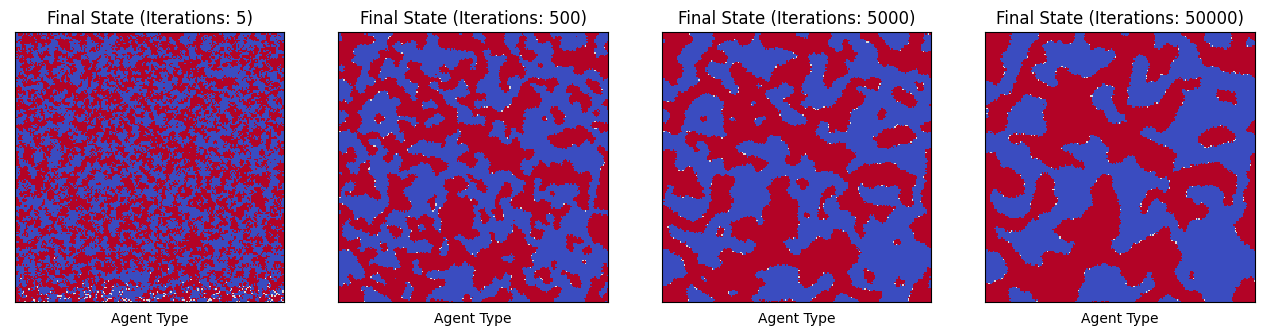

In [31]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()



#### 6/7

In [11]:
jt = 6/7-0.01
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)


# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

Iteration 1 - Unhappy agents: 38376
Iteration 1 - Unhappy agents: 36162
Iteration 100 - Unhappy agents: 24441
Iteration 200 - Unhappy agents: 21723
Iteration 300 - Unhappy agents: 20305
Iteration 400 - Unhappy agents: 19598
Iteration 500 - Unhappy agents: 18963
Iteration 1 - Unhappy agents: 18940
Iteration 100 - Unhappy agents: 16005
Iteration 200 - Unhappy agents: 14667
Iteration 300 - Unhappy agents: 14042
Iteration 400 - Unhappy agents: 13530
Iteration 500 - Unhappy agents: 13199
Iteration 600 - Unhappy agents: 13046
Iteration 700 - Unhappy agents: 12755
Iteration 800 - Unhappy agents: 12383
Iteration 900 - Unhappy agents: 12354
Iteration 1000 - Unhappy agents: 12103
Iteration 1100 - Unhappy agents: 12025
Iteration 1200 - Unhappy agents: 11939
Iteration 1300 - Unhappy agents: 11871
Iteration 1400 - Unhappy agents: 11957
Iteration 1500 - Unhappy agents: 11847
Iteration 1600 - Unhappy agents: 11729
Iteration 1700 - Unhappy agents: 11573
Iteration 1800 - Unhappy agents: 11566
Iteration

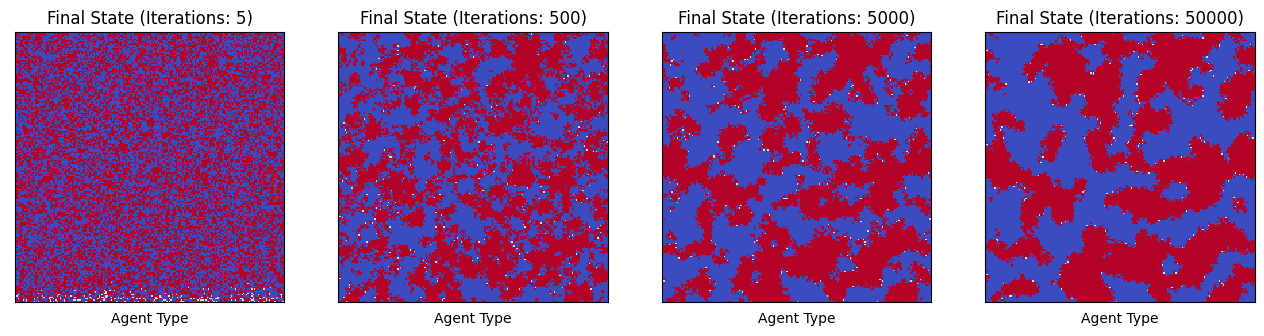

In [12]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()



#### no aging

In [3]:
jt = 5/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)


# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

In [5]:
def main_loop(grid, jt, max_iter):
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    iterations = 0

    while iterations < max_iter:
        fraction_blue, fraction_red = compute_fraction(grid, kernel)
        unhappy_cells = find_unhappy_cells(grid, fraction_blue, fraction_red, jt)

        for pos in zip(*np.where(unhappy_cells)):
            x, y = pos

            # Get the current list of empty cells
            empty_cells = np.where(grid == 0)

            # If there are no satisfying positions, move to a random empty position
            if len(empty_cells[0]) == 0:
                random_empty_index = np.random.choice(len(empty_cells[0]), 1)[0]
                new_x, new_y = empty_cells[0][random_empty_index], empty_cells[1][random_empty_index]
            else:
                # Filter satisfying positions based on agent type
                if grid[x, y] == 1:  # Blue agent
                    satisfying_positions = [(i, j) for i, j in zip(*empty_cells) if fraction_blue[i, j] >= jt]
                else:  # Red agent
                    satisfying_positions = [(i, j) for i, j in zip(*empty_cells) if fraction_red[i, j] >= jt]

                # If satisfying positions are available, move to one of them
                if satisfying_positions:
                    new_x, new_y = satisfying_positions[np.random.randint(len(satisfying_positions))]
                # Otherwise, move to a random empty position
                else:
                    random_empty_index = np.random.choice(len(empty_cells[0]), 1)[0]
                    new_x, new_y = empty_cells[0][random_empty_index], empty_cells[1][random_empty_index]

            # Move the agent
            grid[new_x, new_y] = grid[x, y]
            grid[x, y] = 0

        iterations += 1
        if iterations % 100 == 0 or iterations == 1:
            print(f'Iteration {iterations} - Unhappy agents: {np.sum(unhappy_cells)}')

    return iterations, grid


Iteration 1 - Unhappy agents: 34076
Iteration 1 - Unhappy agents: 15240
Iteration 100 - Unhappy agents: 2657
Iteration 200 - Unhappy agents: 1955
Iteration 300 - Unhappy agents: 1678
Iteration 400 - Unhappy agents: 1463
Iteration 500 - Unhappy agents: 1371
Iteration 1 - Unhappy agents: 1391
Iteration 100 - Unhappy agents: 1198
Iteration 200 - Unhappy agents: 1096
Iteration 300 - Unhappy agents: 1014
Iteration 400 - Unhappy agents: 969
Iteration 500 - Unhappy agents: 985
Iteration 600 - Unhappy agents: 924
Iteration 700 - Unhappy agents: 897
Iteration 800 - Unhappy agents: 884
Iteration 900 - Unhappy agents: 891
Iteration 1000 - Unhappy agents: 849
Iteration 1100 - Unhappy agents: 833
Iteration 1200 - Unhappy agents: 847
Iteration 1300 - Unhappy agents: 847
Iteration 1400 - Unhappy agents: 808
Iteration 1500 - Unhappy agents: 780
Iteration 1600 - Unhappy agents: 784
Iteration 1700 - Unhappy agents: 778
Iteration 1800 - Unhappy agents: 788
Iteration 1900 - Unhappy agents: 764
Iteration 2

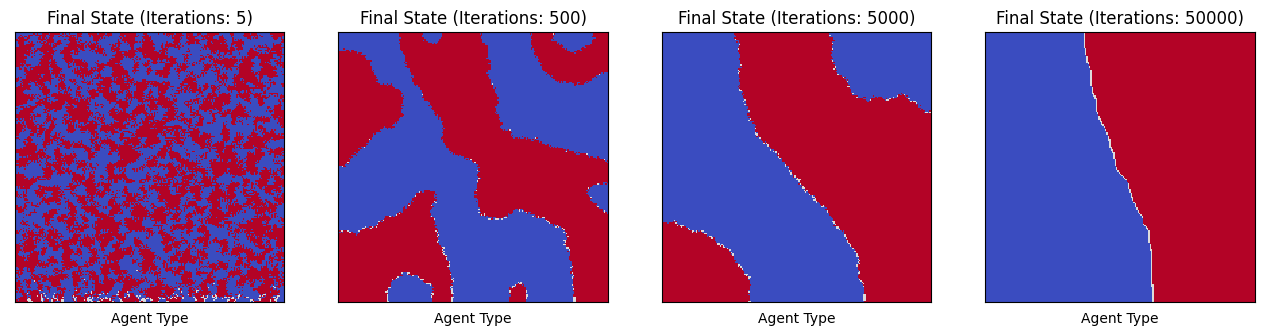

In [6]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()



In [7]:
jt = 4/7
empty_space = 0.005
Nb = int((40000*(1-empty_space))/2)
Nr = int((40000*(1-empty_space))/2)


# Initialize the grid
grid_in = initialize_grid(Nb, Nr)

Iteration 1 - Unhappy agents: 25384
Iteration 1 - Unhappy agents: 4903
Iteration 100 - Unhappy agents: 901
Iteration 200 - Unhappy agents: 682
Iteration 300 - Unhappy agents: 593
Iteration 400 - Unhappy agents: 474
Iteration 500 - Unhappy agents: 430
Iteration 1 - Unhappy agents: 443
Iteration 100 - Unhappy agents: 391
Iteration 200 - Unhappy agents: 334
Iteration 300 - Unhappy agents: 303
Iteration 400 - Unhappy agents: 295
Iteration 500 - Unhappy agents: 267
Iteration 600 - Unhappy agents: 241
Iteration 700 - Unhappy agents: 242
Iteration 800 - Unhappy agents: 241
Iteration 900 - Unhappy agents: 239
Iteration 1000 - Unhappy agents: 229
Iteration 1100 - Unhappy agents: 230
Iteration 1200 - Unhappy agents: 225
Iteration 1300 - Unhappy agents: 221
Iteration 1400 - Unhappy agents: 228
Iteration 1500 - Unhappy agents: 237
Iteration 1600 - Unhappy agents: 226
Iteration 1700 - Unhappy agents: 217
Iteration 1800 - Unhappy agents: 218
Iteration 1900 - Unhappy agents: 199
Iteration 2000 - Unha

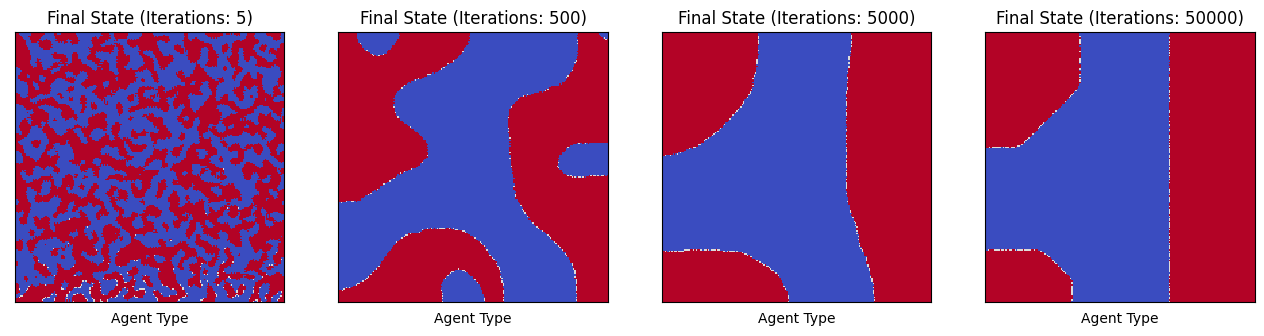

In [8]:

# Create subplots for initial and final states
fig, axes = plt.subplots(1, 4, figsize=(16,8))

iterations, grid_new = main_loop(grid_in, jt, 5)
# Display the initial state of the grid
axes[0].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none')
axes[0].set_title(f'Final State (Iterations: {iterations})')
axes[0].set_xlabel('Agent Type')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Run the main loop with the specified threshold and maximum iterations
iterations, grid_new = main_loop(grid_in, jt, 500)

# Display the final state of the grid
axes[1].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[1].set_title(f'Final State (Iterations: {iterations})')
axes[1].set_xlabel('Agent Type')
axes[1].set_xticks([])
axes[1].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 5000)

# Display the final state of the grid
axes[2].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[2].set_title(f'Final State (Iterations: {iterations})')
axes[2].set_xlabel('Agent Type')
axes[2].set_xticks([])
axes[2].set_yticks([])

iterations, grid_new = main_loop(grid_in, jt, 50000)

# Display the final state of the grid
axes[3].imshow(grid_new, cmap='coolwarm', vmin=-1, vmax=1,interpolation='none')
axes[3].set_title(f'Final State (Iterations: {iterations})')
axes[3].set_xlabel('Agent Type')
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()

